In [2]:
import os
os.environ["KERAS_BACKEND"] = "tensorflow"
import keras_core as keras
import keras_cv

import gc
import cv2
import pydicom
from joblib import Parallel, delayed

import tensorflow as tf
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
from glob import glob

import warnings
warnings.filterwarnings("ignore")

In [3]:
BASE_PATH = "/kaggle/input/rsna-2023-abdominal-trauma-detection"
IMAGE_DIR = "/tmp/dataset/rsna-atd"
INPUT_MODEL_PATH = "/kaggle/input/kerascv-starter-notebook-train/rsna-atd.keras"
MODEL_PATH = "/kaggle/working/rsna-atd.keras"
STRIDE = 10

In [4]:
class Config:
    IMAGE_SIZE = [256, 256]
    RESIZE_DIM = 256
    BATCH_SIZE = 64
    AUTOTUNE = tf.data.AUTOTUNE
    TARGET_COLS  = ["bowel_healthy", "bowel_injury", "extravasation_healthy",
                   "extravasation_injury", "kidney_healthy", "kidney_low",
                   "kidney_high", "liver_healthy", "liver_low", "liver_high",
                   "spleen_healthy", "spleen_low", "spleen_high"]

config = Config()

In [5]:
model = keras_cv.models.ResNetBackbone.from_preset("resnet50_imagenet")

Attaching 'config.json' from model 'keras/resnetv1/keras/resnet50_imagenet/2' to your Kaggle notebook...
Attaching 'config.json' from model 'keras/resnetv1/keras/resnet50_imagenet/2' to your Kaggle notebook...
Attaching 'model.weights.h5' from model 'keras/resnetv1/keras/resnet50_imagenet/2' to your Kaggle notebook...


In [6]:
model.summary()

Model: "res_net50_backbone"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, None, None, 3)]      0         []                            
                                                                                                  
 rescaling (Rescaling)       (None, None, None, 3)        0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, None, None, 64)       9408      ['rescaling[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, None, None, 64)       256       ['conv1_conv[0][0]']          
 on)                                                                             

In [7]:
meta_df = pd.read_csv(f"{BASE_PATH}/test_series_meta.csv")

num_rows = meta_df.shape[0]
unique_patients = meta_df["patient_id"].nunique()

print(f"{num_rows=}")
print(f"{unique_patients=}")

num_rows=6
unique_patients=3


In [8]:
meta_df["dicom_folder"] = BASE_PATH + "/" + "test_images"\
                                    + "/" + meta_df.patient_id.astype(str)\
                                    + "/" + meta_df.series_id.astype(str)

test_folders = meta_df.dicom_folder.tolist()
test_paths = []
for folder in tqdm(test_folders):
    test_paths += sorted(glob(os.path.join(folder, "*dcm")))[::STRIDE]

  0%|          | 0/6 [00:00<?, ?it/s]

In [9]:
test_df = pd.DataFrame(test_paths, columns=["dicom_path"])
test_df["patient_id"] = test_df.dicom_path.map(lambda x: x.split("/")[-3]).astype(int)
test_df["series_id"] = test_df.dicom_path.map(lambda x: x.split("/")[-2]).astype(int)
test_df["instance_number"] = test_df.dicom_path.map(lambda x: x.split("/")[-1].replace(".dcm","")).astype(int)

test_df["image_path"] = f"{IMAGE_DIR}/test_images"\
                    + "/" + test_df.patient_id.astype(str)\
                    + "/" + test_df.series_id.astype(str)\
                    + "/" + test_df.instance_number.astype(str) +".png"

test_df.head(2)

,dicom_path,patient_id,series_id,instance_number,image_path
0,/kaggle/input/rsna-2023-abdominal-trauma-detec...,48843,62825,30,/tmp/dataset/rsna-atd/test_images/48843/62825/...
1,/kaggle/input/rsna-2023-abdominal-trauma-detec...,50046,24574,30,/tmp/dataset/rsna-atd/test_images/50046/24574/...


In [10]:
# Checking if patients are repeated by finding the number of unique patient IDs
num_rows = test_df.shape[0]
unique_patients = test_df["patient_id"].nunique()

print(f"{num_rows=}")
print(f"{unique_patients=}")

num_rows=3
unique_patients=3


In [11]:
os.makedirs(f"{IMAGE_DIR}/train_images", exist_ok=True)
os.makedirs(f"{IMAGE_DIR}/test_images", exist_ok=True)

In [12]:
def standardize_pixel_array(dcm):
    # Correct DICOM pixel_array if PixelRepresentation == 1.
    pixel_array = dcm.pixel_array
    if dcm.PixelRepresentation == 1:
        bit_shift = dcm.BitsAllocated - dcm.BitsStored
        dtype = pixel_array.dtype 
        new_array = (pixel_array << bit_shift).astype(dtype) >>  bit_shift
        pixel_array = pydicom.pixel_data_handlers.util.apply_modality_lut(new_array, dcm)
    return pixel_array

def read_xray(path, fix_monochrome=True):
    dicom = pydicom.dcmread(path)
    data = standardize_pixel_array(dicom)
    data = data - np.min(data)
    data = data / (np.max(data) + 1e-5)
    if fix_monochrome and dicom.PhotometricInterpretation == "MONOCHROME1":
        data = 1.0 - data
    return data

def resize_and_save(file_path):
    img = read_xray(file_path)
    h, w = img.shape[:2]  # orig hw
    img = cv2.resize(img, (config.RESIZE_DIM, config.RESIZE_DIM), cv2.INTER_LINEAR)
    img = (img * 255).astype(np.uint8)
    
    sub_path = file_path.split("/",4)[-1].split(".dcm")[0] + ".png"
    infos = sub_path.split("/")
    sub_path = file_path.split("/",4)[-1].split(".dcm")[0] + ".png"
    infos = sub_path.split("/")
    pid = infos[-3]
    sid = infos[-2]
    iid = infos[-1]; iid = iid.replace(".png","")
    new_path = os.path.join(IMAGE_DIR, sub_path)
    os.makedirs(new_path.rsplit("/",1)[0], exist_ok=True)
    cv2.imwrite(new_path, img)
    return

In [13]:
%%time

file_paths = test_df.dicom_path.tolist()
_ = Parallel(n_jobs=2, backend="threading")(
    delayed(resize_and_save)(file_path) for file_path in tqdm(file_paths, leave=True, position=0)
)

del _; gc.collect()

  0%|          | 0/3 [00:00<?, ?it/s]

CPU times: user 323 ms, sys: 23.6 ms, total: 347 ms
Wall time: 372 ms


569

In [14]:
def decode_image(image_path):
    file_bytes = tf.io.read_file(image_path)
    image = tf.io.decode_png(file_bytes, channels=3, dtype=tf.uint8)
    image = tf.image.resize(image, config.IMAGE_SIZE, method="bilinear")
    image = tf.cast(image, tf.float32) / 255.0
    return image

def build_dataset(image_paths):
    ds = (
        tf.data.Dataset.from_tensor_slices(image_paths)
        .map(decode_image, num_parallel_calls=config.AUTOTUNE)
        .shuffle(config.BATCH_SIZE * 10)
        .batch(config.BATCH_SIZE)
        .prefetch(config.AUTOTUNE)
    )
    return ds

In [15]:
paths  = test_df.image_path.tolist()

ds = build_dataset(paths)
images = next(iter(ds))

images.shape

TensorShape([3, 256, 256, 3])

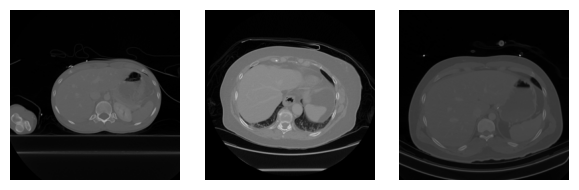

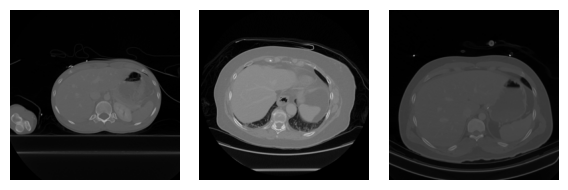

In [16]:
keras_cv.visualization.plot_image_gallery(
    images=images,
    value_range=(0, 1),
    rows=1,
    cols=3,
)

In [17]:
def post_proc(pred):
    proc_pred = np.empty((pred.shape[0], 2*2 + 3*3), dtype="float32")

    # bowel, extravasation
    proc_pred[:, 0] = pred[:, 0]
    proc_pred[:, 1] = 1 - proc_pred[:, 0]
    proc_pred[:, 2] = pred[:, 1]
    proc_pred[:, 3] = 1 - proc_pred[:, 2]
    
    # liver, kidney, sneel
    proc_pred[:, 4:7] = pred[:, 2:5]
    proc_pred[:, 7:10] = pred[:, 5:8]
    proc_pred[:, 10:13] = pred[:, 8:11]

    return proc_pred

In [18]:
# Getting unique patient IDs from test dataset
patient_ids = test_df["patient_id"].unique()

# Initializing array to store predictions
patient_preds = np.zeros(
    shape=(len(patient_ids), 2*2 + 3*3),
    dtype="float32"
)

# Iterating over each patient
for pidx, patient_id in tqdm(enumerate(patient_ids), total=len(patient_ids), desc="Patients "):
    print(f"Patient ID: {patient_id}")
    
    # Query the dataframe for a particular patient
    patient_df = test_df.query("patient_id == @patient_id")
    
    # Getting image paths for a patient
    patient_paths = patient_df.image_path.tolist()

    # Building dataset for prediction
    dtest = build_dataset(patient_paths)
    
    # Predicting with the model
    pred = model.predict(dtest)
    pred = np.concatenate(pred, axis=-1).astype("float32")
    pred = pred[:len(patient_paths), :]
    pred = np.mean(pred, axis=0, keepdims=True)

    # Correcting reshape operation
    pred = pred.reshape(len(patient_paths), -1)

    # Update the array of patient predictions
    patient_preds[pidx, :] += post_proc(pred)[0]
    

    # Deleting variables to free up memory 
    del patient_df, patient_paths, dtest, pred; gc.collect()

Patients :   0%|          | 0/3 [00:00<?, ?it/s]

Patient ID: 48843
1/1 [==============================] - 3s 3s/step
Patient ID: 50046
1/1 [==============================] - 0s 25ms/step
Patient ID: 63706
1/1 [==============================] - 0s 23ms/step


In [19]:
# Create Submission
pred_df = pd.DataFrame({"patient_id":patient_ids,})
pred_df[config.TARGET_COLS] = patient_preds.astype("float32")

# Align with sample submission
pre_df = pd.read_csv(f"{BASE_PATH}/sample_submission.csv")
pre_df = pre_df[["patient_id"]]
pre_df = pre_df.merge(pred_df, on="patient_id", how="left")

# Store submission
pre_df.to_csv("submission.csv",index=False)

In [20]:
pre_df

,patient_id,bowel_healthy,bowel_injury,extravasation_healthy,extravasation_injury,kidney_healthy,kidney_low,kidney_high,liver_healthy,liver_low,liver_high,spleen_healthy,spleen_low,spleen_high
0,48843,0.0,1.0,0.0,1.0,0.0,0.069703,0.0,0.0,0.0,0.0,0.0,0.523548,0.436484
1,50046,0.0,1.0,0.0,1.0,0.0,0.081996,0.0,0.0,0.0,0.0,0.0,0.503222,0.395413
2,63706,0.0,1.0,0.0,1.0,0.0,0.075756,0.0,0.0,0.0,0.0,0.0,0.517313,0.434858


In [33]:
# getting accuracy of pre_df
accuracy = (binary_predictions == pre_df[config.TARGET_COLS]).mean()
print(accuracy * 100)

bowel_healthy            100.0
bowel_injury             100.0
extravasation_healthy    100.0
extravasation_injury     100.0
kidney_healthy           100.0
kidney_low                 0.0
kidney_high              100.0
liver_healthy            100.0
liver_low                100.0
liver_high               100.0
spleen_healthy           100.0
spleen_low                 0.0
spleen_high                0.0
dtype: float64


In [35]:
# Print column names in config.TARGET_COLS
print("Columns in config.TARGET_COLS:")
print(config.TARGET_COLS)

# Print column names in test_df
print("\nColumns in test_df:")
print(test_df.columns)


Columns in config.TARGET_COLS:
['bowel_healthy', 'bowel_injury', 'extravasation_healthy', 'extravasation_injury', 'kidney_healthy', 'kidney_low', 'kidney_high', 'liver_healthy', 'liver_low', 'liver_high', 'spleen_healthy', 'spleen_low', 'spleen_high']

Columns in test_df:
Index(['dicom_path', 'patient_id', 'series_id', 'instance_number',
       'image_path'],
      dtype='object')


In [37]:
# Merge ground truth labels with predictions based on patient IDs
merged_df = pre_df.merge(test_df, on="patient_id", how="left")

# Get columns for comparison
prediction_cols = config.TARGET_COLS
ground_truth_cols = config.TARGET_COLS

# Compare binary predictions with ground truth labels
accuracy = (merged_df[prediction_cols] == merged_df[ground_truth_cols]).mean()
print("Accuracy:", accuracy * 100)

Accuracy: bowel_healthy            100.0
bowel_injury             100.0
extravasation_healthy    100.0
extravasation_injury     100.0
kidney_healthy           100.0
kidney_low               100.0
kidney_high              100.0
liver_healthy            100.0
liver_low                100.0
liver_high               100.0
spleen_healthy           100.0
spleen_low               100.0
spleen_high              100.0
dtype: float64
